<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#FAISS" data-toc-modified-id="FAISS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>FAISS</a></span><ul class="toc-item"><li><span><a href="#Urls" data-toc-modified-id="Urls-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Urls</a></span></li></ul></li><li><span><a href="#Example-20newsgroup" data-toc-modified-id="Example-20newsgroup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example 20newsgroup</a></span></li><li><span><a href="#Building-an-index-and-adding-the-vectors-to-it" data-toc-modified-id="Building-an-index-and-adding-the-vectors-to-it-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Building an index and adding the vectors to it</a></span><ul class="toc-item"><li><span><a href="#Searching" data-toc-modified-id="Searching-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Searching</a></span></li></ul></li><li><span><a href="#Benchmarking-hyperparams" data-toc-modified-id="Benchmarking-hyperparams-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Benchmarking hyperparams</a></span></li></ul></div>

## FAISS


What is similarity search?

Given a set of vectors x_i in dimension d, Faiss build a data structure in RAM from it. After the structure is constructed, when given a new vector x in dimension d it performs efficiently the operation:

$$
i = argmin_i ||x - x_i||
$$

where $||.||$ is the Euclidean distance (L2).

If Faiss terms, the data structure is an index, an object that has an add method to add $x_i$ vectors. Note that the $x_i$'s are assumed to be fixed.

Computing the argmin is the search operation on the index.

This is all what Faiss is about. It can also:

- return not just the nearest neighbor, but also the 2nd nearest, 3rd, ..., k-th nearest neighbor

- search several vectors at a time rather than one (batch processing). For many index types, this is faster than searching one vector after another

- trade precision for speed, ie. give an incorrect result 10% of the time with a method that's 10x faster or uses 10x less memory

- perform maximum inner product search $argmax_i <x, x_i>$ instead of minimum Euclidean search. There is also limited support for other distances (L1, Linf, etc.).

- return all elements that are within a given radius of the query point (range search)

- store the index on disk rather than in RAM.



### Urls

https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/

https://github.com/facebookresearch/faiss/wiki



## Example 20newsgroup

In [240]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

n_features = 1000
newsgroups_train = fetch_20newsgroups(subset='train')
print(f'Number of examples: {len(newsgroups_train.data)}')


document_embedding = CountVectorizer(max_features=n_features)
X_tr = document_embedding.fit_transform(newsgroups_train.data)
X_tr_dense = X_tr.toarray()
X_tr_dense = X_tr_dense.astype('float32')
print(f'Data shape: {X_tr_dense.shape}')

Number of examples: 11314
Data shape: (11314, 1000)


## Building an index and adding the vectors to it

Faiss is built around the Index object. It encapsulates the set of database vectors, and optionally preprocesses them to make searching efficient. There are many types of indexes, we are going to use the simplest version that just performs brute-force L2 distance search on them: IndexFlatL2.

All indexes need to know when they are built which is the dimensionality of the vectors they operate on, d in our case. Then, most of the indexes also require a training phase, to analyze the distribution of the vectors. For IndexFlatL2, we can skip this operation.

When the index is built and trained, two operations can be performed on the index: add and search.

To add elements to the index, we call add on xb. We can also display the two state variables of the index: is_trained, a boolean that indicates whether training is required and ntotal, the number of indexed vectors.

Some indexes can also store integer IDs corresponding to each of the vectors (but not IndexFlatL2). If no IDs are provided, add just uses the vector ordinal as the id, ie. the first vector gets 0, the second 1, etc.



In [241]:
n_examples, n_features = X_tr_dense.shape
n_examples, n_features


(11314, 1000)

In [243]:
import faiss                  

# build the index
index = faiss.IndexFlatL2(n_features)  
print(index.is_trained,index.ntotal)

# add vectors to the index
index.add(X_tr_dense)                
print(index.is_trained,index.ntotal)

True 0
True 11314


### Searching

The basic search operation that can be performed on an index is the k-nearest-neighbor search, ie. for each query vector, find its k nearest neighbors in the database.

The result of this operation can be conveniently stored in an integer matrix of size nq-by-k, where row i contains the IDs of the neighbors of query vector i, sorted by increasing distance. In addition to this matrix, the search operation returns a nq-by-k floating-point matrix with the corresponding squared distances.

As a sanity check, we can first search a few database vectors, to make sure the nearest neighbor is indeed the vector itself.



In [245]:
X_tr_dense[0:3]

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [246]:
# we want to see 4 nearest neighbors
k = 4         
j = 30
# sanity check
D, I = index.search(X_tr_dense[j:j+1], k) 

In [247]:
D

array([[  0., 284., 355., 374.]], dtype=float32)

In [248]:
# Note that 30 appears in the first position since 
# our query is example j=30
I

array([[   30, 10341,  8045,   297]])

Note that we can search using a full matrix where examples correspond to rows

In [249]:
D, I = index.search(X_tr_dense[j:j+5], k) 

In [250]:
D

array([[  0., 284., 355., 374.],
       [  0., 180., 183., 190.],
       [  0.,  36.,  37.,  37.],
       [  0., 611., 626., 667.],
       [  0.,  64.,  75.,  83.]], dtype=float32)

In [251]:
I

array([[   30, 10341,  8045,   297],
       [   31,   362,  1435,  1785],
       [   32,  8596,  9103,  3472],
       [   33,  6722, 11143,  3928],
       [   34,  4904,  3184, 11230]])

In [188]:
def jaccard_similarity(s1,s2):
    return len(s1.intersection(s2))/len(s1)

def euclidean_dist(q, X):
    return np.linalg.norm(q-X,axis=1)

def sorted_distances(q, X, d, K):
    return np.sort(d(q,X))[0:K]

def sorted_indices(q, X, d, K):
    return np.argsort(d(q,X))[0:K]

def find_knn(q, X, K, dist):
    distances = dist(q, X)
    idx_sorted = np.argsort(distances)
    return idx_sorted[0:K]

In [297]:
m = 30
q = X_tr_dense[m,:]
nn_ids = find_knn(q,X_tr_dense, K, dist=euclidean_dist)
approx_nn_dist,approx_nn_ids = index.search(X_tr_dense[m:m+3],K)    

In [301]:
approx_nn_ids[0]

array([   30, 10341,  8045,   297, 10742,   623,  2375,  3092,  6863,
         625,  3823,  8371,  7807, 11286,  8950,  6252,  2687, 10047,
         695,  9595])

In [302]:
nn_ids

array([   30, 10341,  8045,   297,   623, 10742,  2375,  3092,   625,
        6863,  3823,  7807,  8371,  8950, 11286,  6252,  2687, 10047,
         695,  9595])

In [311]:
faiss_knn = faiss.IndexFlatL2(n_features)  
faiss_knn.add(X_tr_dense)                

In [313]:
K = 20
jaccard_similarities =  []
for m in items:
    q = X_tr_dense[m,:]
    nn_ids = find_knn(q,X_tr_dense, K, dist=euclidean_dist)
    approx_nn_dist,approx_nn_ids = faiss_knn.search(X_tr_dense[[m]],K)
    approx_nn_ids = approx_nn_ids.flatten()
    jaccard_sim = jaccard_similarity(set(nn_ids.tolist()), set(approx_nn_ids.tolist()))
    jaccard_similarities.append( jaccard_sim)

In [315]:
np.mean(jaccard_similarities)

0.97

Training an index

In [354]:
m = 10
nlist = 4
quantizer = faiss.IndexFlatL2(n_features)  
faiss_knn = faiss.IndexIVFFlat(quantizer, n_features, nlist)
faiss_knn.train(X_tr_dense)
faiss_knn.add(X_tr_dense)

In [355]:
approx_nn_dist,approx_nn_ids = faiss_knn.search(X_tr_dense[[m]],K)
approx_nn_ids

array([[   10,  6536,  1807, 10235,  9281,  2062,   360, 10801,  5101,
         1893,  2862,  7592,  1378,  5575,  4776,  8881,  7654,  5148,
         2074,    64]])

In [356]:
K = 20
jaccard_similarities =  []
for m in items:
    q = X_tr_dense[m,:]
    nn_ids = find_knn(q,X_tr_dense, K, dist=euclidean_dist)
    approx_nn_dist,approx_nn_ids = faiss_knn.search(X_tr_dense[[m]],K)
    approx_nn_ids = approx_nn_ids.flatten()
    jaccard_sim = jaccard_similarity(set(nn_ids.tolist()), set(approx_nn_ids.tolist()))
    jaccard_similarities.append( jaccard_sim)

In [357]:
np.mean(jaccard_similarities)

0.9305

## Benchmarking hyperparams

In [377]:
np.random.seed(1234)
n_items = 100
items = np.random.randint(0, n_examples, n_items)
nlist_list = [1,2,3,4,5,10,20,30,40]
K = 20

In [378]:
n_examples, n_features, K

(11314, 1000, 20)

In [384]:
jaccard_similarities = {}
query_times = {}

for nlist in nlist_list:
    print(f"Computing with K={K}, nlist={nlist}, n_examples={n_examples}, n_features={n_features}")
    quantizer = faiss.IndexFlatL2(n_features)  
    faiss_knn = faiss.IndexIVFFlat(quantizer, n_features, nlist)
    faiss_knn.train(X_tr_dense)
    faiss_knn.add(X_tr_dense)
    jaccard_sims = []
    
    # time the approximate nearest neighbors retrieval 
    q_time = %timeit -o faiss_knn.search(X_tr_dense[0:2],K)
    query_times[nlist] = q_time.average
    
    for m in items:
        q = X_tr_dense[m,:]
        nn_ids = find_knn(q, X_tr_dense, K, dist=euclidean_dist)        
        approx_nn_dist,approx_nn_ids = faiss_knn.search(X_tr_dense[[m]],K)
        approx_nn_ids = approx_nn_ids.flatten()
        
        jaccard_sim = jaccard_similarity(set(nn_ids.tolist()), 
                                         approx_nn_ids.flatten().tolist())
        jaccard_sims.append(jaccard_sim)

    mean_jaccards = np.mean(jaccard_sims)
    print(f'jaccard mean={mean_jaccards}')
    jaccard_similarities[nlist] = mean_jaccards

Computing with K=20, nlist=1, n_examples=11314, n_features=1000
3.81 ms ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
jaccard mean=0.97
Computing with K=20, nlist=2, n_examples=11314, n_features=1000
3.65 ms ± 43.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
jaccard mean=0.966
Computing with K=20, nlist=3, n_examples=11314, n_features=1000
3.34 ms ± 67.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
jaccard mean=0.9615
Computing with K=20, nlist=4, n_examples=11314, n_features=1000
2.91 ms ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
jaccard mean=0.9305
Computing with K=20, nlist=5, n_examples=11314, n_features=1000
1.83 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
jaccard mean=0.8310000000000001
Computing with K=20, nlist=10, n_examples=11314, n_features=1000
1.37 ms ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
jaccard mean=0.7395000000000002
Computing with K=20, nlist=20, n_examples

In [385]:
import pandas as pd
df_results = pd.DataFrame([query_times,jaccard_similarities]).T

In [386]:
df_results.columns = ["query_time_K", "jaccard_similarity_top_K"]
df_results.index.name = ('nlist')
df_results

,query_time_K,jaccard_similarity_top_K
nlist,,
1,0.003806,0.9700
2,0.003646,0.9660
3,0.003337,0.9615
4,0.002907,0.9305
5,0.001829,0.8310
10,0.001372,0.7395
20,0.000492,0.5325
30,0.000451,0.4515
40,0.000410,0.3935


<AxesSubplot:title={'center':'query time (ms)'}, xlabel='nlist'>

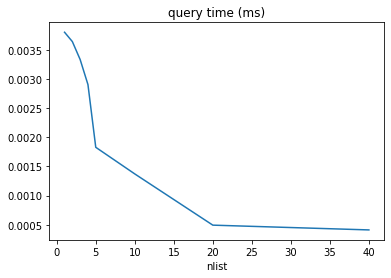

In [387]:
df_results["query_time_K"].plot(title="query time (ms)",xlabel="nlist")

<AxesSubplot:title={'center':'Jaccard agreement top K'}, xlabel='nlist'>

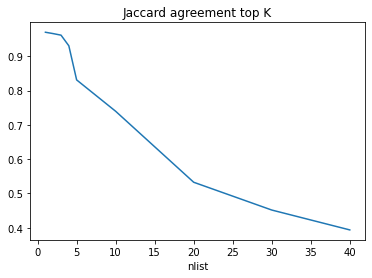

In [388]:
df_results["jaccard_similarity_top_K"].plot(title="Jaccard agreement top K",xlabel="nlist")

Note that the higher `nlist` the longer it takes to query (and the lower chality)